In [1]:
#
# In this notebook we exampine moprhology's rol,e of preicpitaiton system
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from global_land_mask import globe
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from src.regions import *
from src.pf_stats import *
from src.plotting import *
from src.radar import *

In [2]:
CORE_THRESH = 10
regions = [
    cio_region(), 
    wmp_region(), 
    sas_region()
]

In [3]:
pf_stats_dict = {r.name: load_pf_stats(r, maxpr_min=CORE_THRESH, just_tropics=False, trim_region=True) for r in regions}

In [4]:
radar_dict = {r.name: load_merged_radar(r, trim_region=True, maxpr_min=CORE_THRESH)[['max_precip_refl', 'rainiest_10mmhr_cluster_refl_conn8']] for r in regions}

In [5]:
for r in regions:
    pf_size = pf_stats_dict[r.name].shape[0]
    radar_size = radar_dict[r.name].features.size
    print(f"Region {r.name}: pf_stats size = {pf_size}, radar features size = {radar_size}")
    assert(pf_size == radar_size)


Region CIO: pf_stats size = 152870, radar features size = 152870
Region WMP: pf_stats size = 257361, radar features size = 257361
Region SAS: pf_stats size = 105055, radar features size = 105055


In [6]:
maritime_continent_data = {
    'mc_pf_stats': [],
    'mc_radar': []
}
for r, data in pf_stats_dict.items():
    print(r)

    MC_mask = (
         (data['mean_longitude'] <= 170)
         & (data['mean_longitude'] >= 90)
         & (abs(data['mean_latitude'] <= 10))
    )

    maritime_continent_data['mc_pf_stats'].append(data[MC_mask])
    maritime_continent_data['mc_radar'].append(radar_dict[r].isel(features=np.where(MC_mask)[0]))
    
   
maritime_continent_data['mc_pf_stats'] = pd.concat(maritime_continent_data['mc_pf_stats'])
maritime_continent_data['mc_radar'] = xr.concat(maritime_continent_data['mc_radar'], dim='features')

CIO
WMP
SAS


In [8]:
area = maritime_continent_data['mc_pf_stats']['num_pixels'] * 25

loc = (
    maritime_continent_data['mc_pf_stats']['rainiest_10mmhr_cluster_precip_8conn']
    /maritime_continent_data['mc_pf_stats']['total_precip']
)

radar_profs = maritime_continent_data['mc_radar']['rainiest_10mmhr_cluster_refl_conn8']

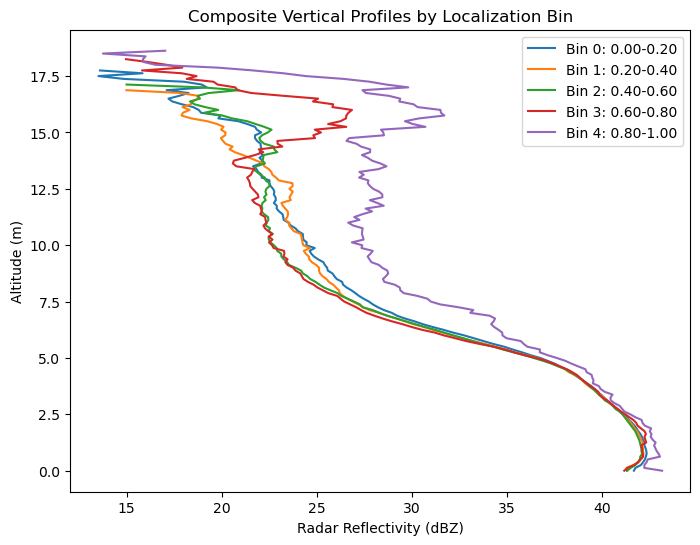

In [16]:
# Define area limits
area_min = 1500   # example lower limit
area_max = 2000 # example upper limit

# Filter features by area using the pandas Series "area"
area_mask = (area >= area_min) & (area <= area_max)
filtered_features = area.index[area_mask]

# Filter loc values to only include those features meeting the area condition.
loc_filtered = loc.loc[filtered_features]

# Define bins for localization (number of bins can be adjusted)
num_bins = 5
bins = np.linspace(0, 1, num_bins + 1)
# Create bin labels (using integer bin indices)
loc_bins = pd.cut(loc_filtered, bins=bins, labels=False, include_lowest=True)

# Initialize dictionary to hold composite profiles for each bin
composite_profiles = {}

# Loop over each bin and compute the mean vertical profile
for bin_val in np.unique(loc_bins):
    # Get the feature indices corresponding to the current bin
    features_in_bin = loc_filtered.index[loc_bins == bin_val].astype(int)
    
    # Ensure that these indices are within the bounds of radar_profs.
    valid_indices = np.intersect1d(features_in_bin, np.arange(radar_profs.sizes['features']))
    
    # Use integer indexing with .isel
    profiles = radar_profs.isel(features=valid_indices)
    
    # Compute the composite (mean) profile along the 'features' dimension.
    composite_profile = profiles.mean(dim='features')

    composite_profile = np.log10(composite_profile)*10
    composite_profiles[bin_val] = composite_profile

# Plot the composite profiles vs. altitude
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for bin_val, composite_profile in composite_profiles.items():
    # Prepare a label that shows the bin range based on loc
    label = f"Bin {bin_val}: {bins[bin_val]:.2f}-{bins[bin_val+1]:.2f}"
    
    # Plot the composite profile.
    # Assuming composite_profile has one data variable (e.g., 'reflectivity')
    # and that its 'alt' coordinate holds the vertical levels.
    plt.plot(composite_profile, composite_profile.alt, label=label)

plt.xlabel("Radar Reflectivity (dBZ)")
plt.ylabel("Altitude (m)")
plt.title("Composite Vertical Profiles by Localization Bin")
plt.legend()
# plt.gca().invert_yaxis()  # Invert y-axis if altitude increases downward
plt.show()


In [35]:
valid_features

array([], dtype='<U68')

/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))


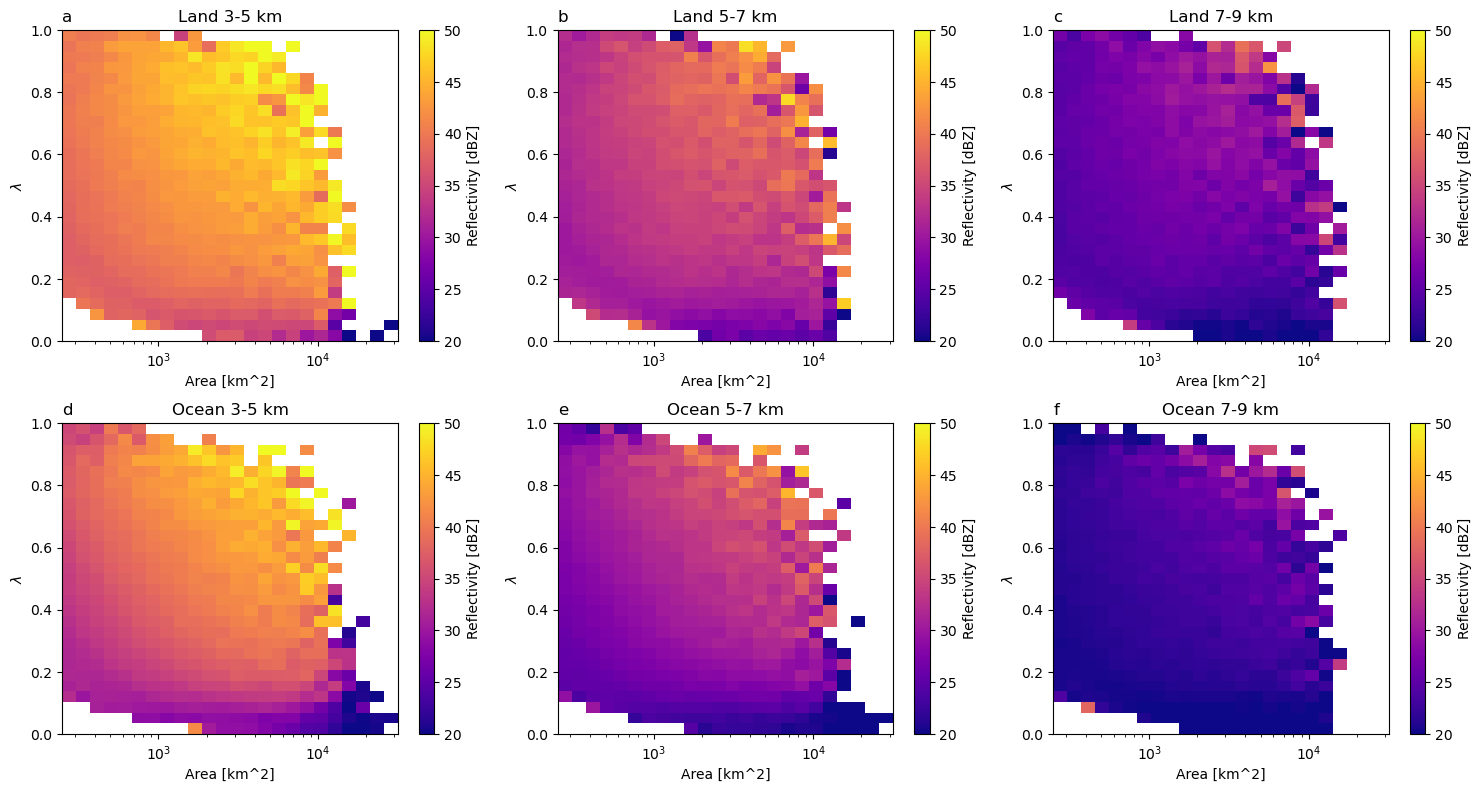

In [47]:
#
# Plot the layer mean reflectivity
#
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 8))

area = pf_stats['num_pixels'] * 25
loc = pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_precip_8conn']/pf_stats['total_precip']
area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)

layer_slices = [slice(3, 5), slice(5, 7), slice(7, 9)]

is_land_id = globe.is_land(pf_stats['mean_latitude'], pf_stats['mean_longitude'])
is_ocean_id = globe.is_ocean(pf_stats['mean_latitude'], pf_stats['mean_longitude'])

land_axs = axs[0,:]
land_radar = radar.isel(features=is_land_id)
for i, ax in enumerate(land_axs):
    mean_z = land_radar['max_precip_refl'].sel(alt=layer_slices[i]).mean('alt')
    mean = binned_statistic_2d(
        loc[is_land_id], 
        area[is_land_id], 
        bins=[loc_bins, area_bins],
        values=np.log10(mean_z) * 10,  # convert reflectivity
        statistic=np.nanmean
    ).statistic
    
    x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
    c = ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        mean,
        cmap=plt.cm.plasma, 
        norm=colors.Normalize(vmin=20, vmax=50)
    )
    # Add colorbar
    fig.colorbar(c, ax=ax, label='Reflectivity [dBZ]')
    
    # Label axes & title
    ax.set_xscale('log')
    ax.set_xlabel('Area [km^2]')
    ax.set_ylabel(r'$\lambda$')
    ax.set_title(f"Land {layer_slices[i].start}-{layer_slices[i].stop} km")
    ax.set_title(chr(ord('a') + i), loc='left')
ocean_axs = axs[1,:]
ocean_radar = radar.isel(features=is_ocean_id)
for i, ax in enumerate(ocean_axs):
    mean_z = ocean_radar['max_precip_refl'].sel(alt=layer_slices[i]).mean('alt')
    mean = binned_statistic_2d(
        loc[is_ocean_id], 
        area[is_ocean_id], 
        bins=[loc_bins, area_bins],
        values=np.log10(mean_z) * 10,
        statistic=np.nanmean
    ).statistic
    
    x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
    c = ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        mean,
        cmap=plt.cm.plasma, 
        norm=colors.Normalize(vmin=20, vmax=50)
    )
    # Add colorbar
    fig.colorbar(c, ax=ax, label='Reflectivity [dBZ]')
    
    # Label axes & title
    ax.set_xscale('log')
    ax.set_xlabel('Area [km^2]')
    ax.set_ylabel(r'$\lambda$')
    ax.set_title(f"Ocean {layer_slices[i].start}-{layer_slices[i].stop} km")
    ax.set_title(chr(ord('d') + i), loc='left')
plt.tight_layout(pad=1)

save_figure(fig, 'Fig04_LayerMeans')